In [1]:
#Assignent4 
#  Merge CDS data with CRSP-Compustat data based on date gvkey and date.


In [2]:
#import package as usual 
from datetime import datetime
import pathlib

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from utils import LabelEncoder, OneHotEncoder
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline

In [3]:
#read cds first
data = pd.read_stata('cds_spread5y_2001_2016.dta',encoding='ascii')
data.head()

,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,impliedrating
0,001038,2004-08-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,MR,0.04,BB
1,001038,2005-08-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.03,BB
2,001038,2005-09-30,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.03,BB
3,001038,2005-10-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.03,BB
4,001038,2005-11-30,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.03,BB


In [4]:
#read compustat data
data2 = pd.read_csv('Quarterly Merged CRSP-Compustat.csv',encoding='ascii')

/Users/broteinlee/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,33,37,654,655,656,657,661,675,676,686) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#convert date to quarter based 
#there are 3 type of quarter
#type I  : 1,4,7,10  
#type II : 2,5,8,11  
#type III: 3,6,9,12  
#For example, 2010/8 will convert into type II quarter 2,so we will use 2010q2 typeII
data2.rename(columns={'GVKEY': 'gvkey'},inplace = True)
data2['qtr'] = pd.PeriodIndex(pd.to_datetime(data2.datadate), freq='Q')

#convert time to type
data2['month'] = pd.DatetimeIndex(data2['datadate']).month
data2['CDSyear'] = pd.DatetimeIndex(data2['datadate']).year

conditions = [
    ((data2['month']%3) == 1) ,
    ((data2['month']%3) == 2),
    ((data2['month']%3) == 0)]
choices = ['I', 'II', 'III']
data2['type'] = np.select(conditions, choices)
data2.head()
#print(data2.columns.tolist())
#print(data.columns.tolist())

,gvkey,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyearq,...,spcsrc,state,stko,weburl,dldte,ipodate,qtr,month,CDSyear,type
0,1038,P,1,LU,66413,6301,08/18/1983,12/31/2004,03/31/2001,2000,...,NaN,MO,0.00,www.amctheatres.com,12/27/2004,NaN,2001Q1,3,2001,III
1,1038,P,1,LU,66413,6301,08/18/1983,12/31/2004,06/30/2001,2001,...,NaN,MO,0.00,www.amctheatres.com,12/27/2004,NaN,2001Q2,6,2001,III
2,1038,P,1,LU,66413,6301,08/18/1983,12/31/2004,09/30/2001,2001,...,NaN,MO,0.00,www.amctheatres.com,12/27/2004,NaN,2001Q3,9,2001,III
3,1038,P,1,LU,66413,6301,08/18/1983,12/31/2004,12/31/2001,2001,...,NaN,MO,0.00,www.amctheatres.com,12/27/2004,NaN,2001Q4,12,2001,III
4,1038,P,1,LU,66413,6301,08/18/1983,12/31/2004,03/31/2002,2001,...,NaN,MO,0.00,www.amctheatres.com,12/27/2004,NaN,2002Q1,3,2002,III


In [6]:
#merge CDS with compustat data
#get the fiscal year and roughly quater
data['qtr'] = pd.PeriodIndex(pd.to_datetime(data.mdate), freq='Q')
data3 = data2[['gvkey', 'qtr', 'type']]
data4 = data.merge(data3, left_on=['gvkey','qtr'], right_on=['gvkey','qtr'])
print(data4)   #empty ?

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [7]:
#check type for debugging
print(data.gvkey.dtype)
print(data2.gvkey.dtype)

#we find the types are different that's why it cannot match 
#convert type object to type int64
data['gvkey'] = data['gvkey'].astype(str).astype(int)
print(data.gvkey.dtype)


object
int64
int64


In [8]:
data4 = data.merge(data3, left_on=['gvkey','qtr'], right_on=['gvkey','qtr'])
data4.head()

,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,impliedrating,qtr,type
0,1038,2004-08-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,MR,0.04,BB,2004Q3,III
1,1045,2002-01-31,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.06,CCC,2002Q1,III
2,1045,2002-02-28,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.06,CCC,2002Q1,III
3,1045,2002-03-31,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.04,CCC,2002Q1,III
4,1045,2002-04-30,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.04,CCC,2002Q2,III


In [9]:
#get the month to set the different condition 
data4['month'] = pd.DatetimeIndex(data4['mdate']).month
data4['year'] = pd.DatetimeIndex(data4['mdate']).year
#For type I, we can just use use normal way to get the qtr
#For typeII & typeIII, we have to transform it to correct month to get the qtr
#For example, in type II we should transfer Jan 2017 to 2016 Q4
conditions = [
    ((data4['type']) == 'I') ,
    ((data4['type']) == "II"),
    ((data4['type']) == "III")]
choices = [(data4['month'] ),
           (data4['month'] - 1),
           (data4['month'] - 2)]
data4['fiscal_month'] = np.select(conditions, choices)

In [10]:
#def get_qtr(df):
#    if df['fiscal_month'] < 0 :
#        df['year'] = df['year'] -1
#        df['fiscal_month2'] = df['fiscal_month']%12
#        df['STATUS_1'] = str(df['year'])+'-'+str(df['fiscal_month2'])
#        return df['STATUS_1']
#    else:
#        df['STATUS_2'] = str(df['year'])+'-'+str(df['fiscal_month'])
#        return df['STATUS_2']
#data4['fiscal_date'] = data4.apply(get_qtr, axis = 1)

#to get the correct year & month 
data4['fiscal_year']= np.where((data4['fiscal_month'])>0, data4['year'], data4['year']-1 )
data4['fiscal_month']= np.where((data4['fiscal_month'])>0, data4['fiscal_month'], data4['fiscal_month']+12)
#print(data4.fiscal_year.dtype)
#print(data4.fiscal_month.dtype)
#print(data4.month.dtype)

#convert it into correct qtr
data4["fiscal_date"] = data4['fiscal_year'].map(str) +'-'+ data4['fiscal_month'].map(str)
data4['fiscal_qtr'] = pd.PeriodIndex(pd.to_datetime(data4.fiscal_date), freq='Q')
data4.head()

,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,impliedrating,qtr,type,month,year,fiscal_month,fiscal_year,fiscal_date,fiscal_qtr
0,1038,2004-08-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,MR,0.04,BB,2004Q3,III,8,2004,6,2004,2004-6,2004Q2
1,1045,2002-01-31,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.06,CCC,2002Q1,III,1,2002,11,2001,2001-11,2001Q4
2,1045,2002-02-28,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.06,CCC,2002Q1,III,2,2002,12,2001,2001-12,2001Q4
3,1045,2002-03-31,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.04,CCC,2002Q1,III,3,2002,1,2002,2002-1,2002Q1
4,1045,2002-04-30,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.04,CCC,2002Q2,III,4,2002,2,2002,2002-2,2002Q1


In [11]:
#make table neat
data5 = data4.drop(['month','qtr', 'year','fiscal_month', 'fiscal_year','fiscal_date'], axis=1)
data5.head()

,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,impliedrating,type,fiscal_qtr
0,1038,2004-08-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,MR,0.04,BB,III,2004Q2
1,1045,2002-01-31,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.06,CCC,III,2001Q4
2,1045,2002-02-28,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.06,CCC,III,2001Q4
3,1045,2002-03-31,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.04,CCC,III,2002Q1
4,1045,2002-04-30,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.04,CCC,III,2002Q1


In [12]:
#merge final CDS(data5) with compustat(data2)
final = data5.merge(data2, left_on=['gvkey','fiscal_qtr','type'], right_on=['gvkey','qtr','type'])
final.head()

,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,impliedrating,type,...,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate,qtr,month,CDSyear
0,1038,2004-08-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,MR,0.04,BB,III,...,978.00,NaN,MO,0.00,www.amctheatres.com,12/27/2004,NaN,2004Q2,6,2004
1,1045,2002-01-31,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.06,CCC,III,...,600.00,D,TX,0.00,www.aa.com,NaN,NaN,2001Q4,12,2001
2,1045,2002-02-28,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.06,CCC,III,...,600.00,D,TX,0.00,www.aa.com,NaN,NaN,2001Q4,12,2001
3,1045,2002-03-31,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.04,CCC,III,...,600.00,D,TX,0.00,www.aa.com,NaN,NaN,2002Q1,3,2002
4,1045,2002-04-30,0A18DB,SNRFOR,AMR,AMR Corp,MR,0.04,CCC,III,...,600.00,D,TX,0.00,www.aa.com,NaN,NaN,2002Q1,3,2002


In [16]:
#Step for Assignment 5 
#1. Impute missing values with median.
#2. Keep only numerical variables.
#3. Remove variables that are all missing.
#4. Divide the dataset to test and train. Consider 2016, 2017, and 2018 data as test and the rest as train.
#5. On the train sample run a Random Forest with 50 trees (note that it may take a while)
#6. Keep the first 50 features with highest feature importance and discard the rest from both test and train.
#7. Using these 50 variables run Random Forest, Gradient Boosting, and XGBoost with 100, 200, 500, and 1000 trees.
#8. Show the relationship between number of trees and “Mean Percentage Error” of test sample in a line graph. 
#   Show the results of all three techniques in a single graph.

In [15]:
final.shape[0]

117728

In [16]:
#total is 1126 different gvkey
final.gvkey.unique().shape[0]

1126

In [13]:
#Check the statistics of the spread from the same gvkey:
company_agg = final.groupby("gvkey")["spread5y"].agg(["count", "min", "max", "sum"]).reset_index()
company_agg.describe()

,gvkey,count,min,max,sum
count,1126.00,1126.00,1126.00,1126.00,1126.00
mean,40711.07,104.55,0.01,0.09,2.00
std,56560.54,79.45,0.02,0.21,3.25
min,1038.00,1.00,0.00,0.00,0.01
25%,6823.00,42.00,0.00,0.02,0.39
50%,13326.50,96.50,0.00,0.04,1.05
75%,60870.50,169.00,0.01,0.07,2.23
max,295786.00,728.00,0.42,2.79,54.47


In [14]:
final = final.drop(['redcode','shortname', 'weburl','LINKPRIM','LIID','LINKTYPE','LPERMNO','LPERMCO','LINKDT','LINKENDDT',
                    'mdate','fiscal_qtr','month','CDSyear','add1','add2','add3','add4','addzip','conm','busdesc','conml',
                    'county','fax','naics','phone','sic','stko','datacqtr', 'datafqtr','fqtr','fyearq','acctchgq','acctstdq',
                    'compstq','finalq','rp','apdedateq','fdateq','pdateq','rdq','fic','ein','fyrc','incorp','datafmt','consol',
                    'popsrc','datafmt','tic','city','cusip','type','datadate','fyr','indfmt','ggroup','gind','gsubind','gsector','cik',
                   ], axis=1)

In [15]:
final.head()

,gvkey,tier,ticker,docclause,spread5y,impliedrating,adrrq,ajexq,ajpq,bsprq,...,prican,prirow,priusa,spcindcd,spcseccd,spcsrc,state,dldte,ipodate,qtr
0,1038,SNRFOR,AEN,MR,0.04,BB,nan,1.00,1.00,NaN,...,NaN,NaN,1,245.00,978.00,NaN,MO,12/27/2004,NaN,2004Q2
1,1045,SNRFOR,AMR,MR,0.06,CCC,nan,1.00,1.00,NaN,...,NaN,NaN,4,605.00,600.00,D,TX,NaN,NaN,2001Q4
2,1045,SNRFOR,AMR,MR,0.06,CCC,nan,1.00,1.00,NaN,...,NaN,NaN,4,605.00,600.00,D,TX,NaN,NaN,2001Q4
3,1045,SNRFOR,AMR,MR,0.04,CCC,nan,1.00,1.00,NaN,...,NaN,NaN,4,605.00,600.00,D,TX,NaN,NaN,2002Q1
4,1045,SNRFOR,AMR,MR,0.04,CCC,nan,1.00,1.00,NaN,...,NaN,NaN,4,605.00,600.00,D,TX,NaN,NaN,2002Q1


#### Start with the gvkey, let gvkey become the index

In [16]:
CDS_uniq_key = final[["gvkey"]].drop_duplicates()
CDS_uniq_key["index"] = range(CDS_uniq_key.shape[0])
#df_uniq_policy.set_index("Policy_Number", inplace=True)
CDS_uniq_key.head()

,gvkey,index
0,1038,0
1,1045,1
153,1075,2
324,1078,3
506,1081,4


In [17]:
encoder = LabelEncoder()
tmp = encoder.fit_transform(final[["curcdq"]])
final["curcdq"] = tmp["curcdq"].astype("int32")
final["curcdq"].head()

/Users/broteinlee/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


0    0
1    0
2    0
3    0
4    0
Name: curcdq, dtype: int32

In [18]:
encoder = LabelEncoder(min_obs=40)
tmp = encoder.fit_transform(final[["curncdq"]])
final["curncdq"] = tmp["curncdq"].astype("int32")
final["curncdq"].head()

/Users/broteinlee/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


0    1
1    1
2    1
3    1
4    1
Name: curncdq, dtype: int32

In [19]:
encoder = LabelEncoder(min_obs=100)
tmp = encoder.fit_transform(final[["state"]])
final["state"] = tmp["state"].astype("int32")
final["state"].head()

/Users/broteinlee/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


0    18
1     3
2     3
3     3
4     3
Name: state, dtype: int32

In [20]:
encoder = LabelEncoder(min_obs=200)
tmp = encoder.fit_transform(final[["qtr"]])
final["qtr"] = tmp["qtr"].astype("int32")


/Users/broteinlee/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [21]:
encoder = LabelEncoder(min_obs=100)
tmp = encoder.fit_transform(final[["loc"]])
final["loc"] = tmp["loc"].astype("int32")
final["loc"].head()

/Users/broteinlee/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


0    1
1    1
2    1
3    1
4    1
Name: loc, dtype: int32

In [22]:
encoder = LabelEncoder(min_obs=20)
tmp = encoder.fit_transform(final[["docclause"]])
final["docclause"] = tmp["docclause"].astype("int32")
final["docclause"].head()

/Users/broteinlee/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


0    0
1    0
2    0
3    0
4    0
Name: docclause, dtype: int32

In [23]:
encoder = LabelEncoder(min_obs=20)
tmp = encoder.fit_transform(final[["impliedrating"]])
final["impliedrating"] = tmp["impliedrating"].astype("int32")
final["impliedrating"].head()

/Users/broteinlee/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


0    2
1    5
2    5
3    5
4    5
Name: impliedrating, dtype: int32

In [24]:
final.head()

,gvkey,tier,ticker,docclause,spread5y,impliedrating,adrrq,ajexq,ajpq,bsprq,...,prican,prirow,priusa,spcindcd,spcseccd,spcsrc,state,dldte,ipodate,qtr
0,1038,SNRFOR,AEN,0,0.04,2,nan,1.00,1.00,NaN,...,NaN,NaN,1,245.00,978.00,NaN,18,12/27/2004,NaN,16
1,1045,SNRFOR,AMR,0,0.06,5,nan,1.00,1.00,NaN,...,NaN,NaN,4,605.00,600.00,D,3,NaN,NaN,61
2,1045,SNRFOR,AMR,0,0.06,5,nan,1.00,1.00,NaN,...,NaN,NaN,4,605.00,600.00,D,3,NaN,NaN,61
3,1045,SNRFOR,AMR,0,0.04,5,nan,1.00,1.00,NaN,...,NaN,NaN,4,605.00,600.00,D,3,NaN,NaN,60
4,1045,SNRFOR,AMR,0,0.04,5,nan,1.00,1.00,NaN,...,NaN,NaN,4,605.00,600.00,D,3,NaN,NaN,60


In [26]:
#1. Impute missing values with median.
CDS_data = final.fillna(0)
#2. Keep only numerical variables.
CDS_data = CDS_data._get_numeric_data()

In [27]:
from sklearn.model_selection import train_test_split
Y_Column = "spread5y"
Y = CDS_data[Y_Column].values
X = CDS_data.drop(Y_Column,axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
   X , Y, test_size=0.2, random_state=42)

In [29]:
y_train

array([0.03918018, 0.00467688, 0.0145    , ..., 0.00855243, 0.00518273,
       0.00211429])

In [30]:
X_train.head()

,gvkey,docclause,impliedrating,adrrq,ajexq,ajpq,curcdq,curncdq,currtrq,curuscnq,...,prchq,prclq,adjex,dlrsn,loc,priusa,spcindcd,spcseccd,state,qtr
36611,6768,0,2,0.00,1.00,1.00,0,1,1.00,0.00,...,15.39,8.25,1.00,1.00,1,1,465.00,976.00,2,37
85328,25279,0,0,0.00,1.00,1.00,0,1,1.00,0.00,...,23.58,16.47,1.00,0.00,1,1,300.00,905.00,9,10
53580,9815,0,0,0.00,1.00,1.00,0,1,1.00,0.00,...,35.81,28.66,1.00,0.00,1,1,210.00,970.00,38,19
37934,6946,0,4,0.00,2.00,2.00,0,1,1.00,0.97,...,85.07,71.29,2.00,0.00,3,1,130.00,976.00,26,44
107683,139662,0,5,0.00,1.00,1.00,0,1,1.00,0.00,...,11.97,8.85,1.00,0.00,1,2,187.00,940.00,4,11


In [31]:
#select dtype = object and del
X_train.select_dtypes(include=['object']).head()

""
36611
85328
53580
37934
107683


In [163]:
X_train = X_train.drop(['gvkey','tier','ticker','bsprq','ogmq','staltq','costat','idbflag','prican','prirow','spcsrc','dldte','ipodate'], axis=1)
X_train.head()

,docclause,impliedrating,adrrq,ajexq,ajpq,curcdq,curncdq,currtrq,curuscnq,scfq,...,prchq,prclq,adjex,dlrsn,loc,priusa,spcindcd,spcseccd,state,qtr
36611,0,2,0.00,1.00,1.00,0,1,1.00,0.00,7.00,...,15.39,8.25,1.00,1.00,1,1,465.00,976.00,2,37
85328,0,0,0.00,1.00,1.00,0,1,1.00,0.00,7.00,...,23.58,16.47,1.00,0.00,1,1,300.00,905.00,9,10
53580,0,0,0.00,1.00,1.00,0,1,1.00,0.00,7.00,...,35.81,28.66,1.00,0.00,1,1,210.00,970.00,38,19
37934,0,4,0.00,2.00,2.00,0,1,1.00,0.97,7.00,...,85.07,71.29,2.00,0.00,3,1,130.00,976.00,26,44
107683,0,5,0.00,1.00,1.00,0,1,1.00,0.00,7.00,...,11.97,8.85,1.00,0.00,1,2,187.00,940.00,4,11


In [164]:
X_test = X_test.drop(['gvkey','tier','ticker','bsprq','ogmq','staltq','costat','idbflag','prican','prirow','spcsrc','dldte','ipodate'], axis=1)
X_test.head()

,docclause,impliedrating,adrrq,ajexq,ajpq,curcdq,curncdq,currtrq,curuscnq,scfq,...,prchq,prclq,adjex,dlrsn,loc,priusa,spcindcd,spcseccd,state,qtr
58252,0,1,0.00,1.00,1.00,1,3,1.00,0.83,7.00,...,30.84,28.94,1.00,0.00,3,1,710.00,700.00,21,7
51710,0,2,0.00,1.00,1.00,0,1,1.00,0.00,7.00,...,57.44,49.09,1.00,1.00,1,1,835.00,800.00,9,10
95503,0,0,0.00,3.00,3.00,0,1,1.00,0.00,7.00,...,73.00,65.00,3.00,0.00,7,1,835.00,800.00,1,14
9473,0,5,0.00,0.52,0.52,0,1,1.00,0.76,7.00,...,48.00,40.58,0.52,0.00,3,5,400.00,970.00,32,18
42247,0,3,0.01,1.00,1.00,0,6,0.01,0.00,7.00,...,26.74,22.00,1.00,0.00,4,90,463.00,974.00,1,9


In [32]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 50 trees
rf2 = RandomForestRegressor(n_estimators = 50)

In [33]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [34]:
X_train

array([[-0.51691311, -0.34890233,  0.21810336, ...,  0.56057436,
        -0.80194543,  0.53100705],
       [-0.15814829, -0.34890233, -1.07694509, ...,  0.1900462 ,
        -0.08582198, -1.02136594],
       [-0.45785869, -0.34890233, -1.07694509, ...,  0.52926212,
         2.88097517, -0.50390828],
       ...,
       [ 1.52586211, -0.34890233, -1.07694509, ...,  0.29442033,
         1.34642492,  0.76098823],
       [-0.62527323, -0.34890233, -0.42942086, ...,  0.1900462 ,
         0.32339142,  0.18603527],
       [-0.58556121, -0.34890233, -1.07694509, ...,  0.57101177,
        -0.29042868, -1.25134713]])

In [35]:
#5 Run Random Forest 
#Do it again for Test and Train
forest_fit2 = rf2.fit(X_train, y_train)

In [36]:
#get the result
y_pred = rf2.predict(X_test) 
print(y_pred)
print("The accuracy of the random forest is ", forest_fit2.score(X_test, y_test))

[0.00336708 0.00222609 0.00741014 ... 0.00284537 0.01603876 0.00637201]
The accuracy of the random forest is  0.8384153864748117


In [39]:
rf2.feature_importances_.argsort()[::-1][:40]

array([618,   2, 260, 189, 524,  29, 523,  95,  77, 382,  66,  91,  92,
       188, 530,  41, 616, 612,   0, 193,  46, 626, 190, 482,  26,  83,
        28, 289, 624, 479, 202, 230, 484,  68,   6, 277, 422,  42,  59,
        49])

In [49]:
#New method for select the feature
def selectKImportance(model, X, k=40):
#     return X.iloc[:,model.feature_importances_.argsort()[::-1][:k]]
    return X[:,model.feature_importances_.argsort()[::-1][:k]]

X_Train = selectKImportance(rf2,X_train,40)   
print(X_Train.shape)

X_Test = selectKImportance(rf2,X_test,40)   
print(X_Test.shape)


(94182, 40)
(23546, 40)


In [41]:
import keras
from keras.models import Sequential
from keras.layers import Dense

/Users/broteinlee/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [55]:
# first step: create a Sequential object, as a sequence of layers. 
# B/C NN is a sequence of layers.
model = Sequential()

In [56]:
# add the first hidden layer
#kernel_initializer is function give you the first weight
#bias_initializer is the intercept
# Adding the input layer and the first hidden layer
model.add(Dense(40,kernel_initializer = 'normal', activation = 'relu'))

In [57]:
# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))

In [58]:
# Adding the thrid hidden layer
model.add(Dense(units = 32, activation = 'relu'))

In [59]:
# Adding the output layer
model.add(Dense(units = 1))

In [60]:
# compiling the NN  #optimizer stochatic gradient descent  
# Minimize the MSE if it is linear
model.compile(optimizer = 'adam',loss = 'mean_absolute_percentage_error')

In [61]:
# train the model

model.fit(X_Train, y_train, batch_size = 5, epochs = 100)

Epoch 1/100
94182/94182 [==============================] - 30s 314us/step - loss: 85.7731
Epoch 2/100
94182/94182 [==============================] - 33s 356us/step - loss: 53.0815
Epoch 3/100
94182/94182 [==============================] - 30s 317us/step - loss: 51.0045
Epoch 4/100
94182/94182 [==============================] - 27s 290us/step - loss: 49.3059
Epoch 5/100
94182/94182 [==============================] - 29s 305us/step - loss: 46.7625
Epoch 6/100
94182/94182 [==============================] - 28s 295us/step - loss: 45.1176
Epoch 7/100
94182/94182 [==============================] - 29s 303us/step - loss: 44.4657
Epoch 8/100
94182/94182 [==============================] - 29s 303us/step - loss: 43.7141
Epoch 9/100
94182/94182 [==============================] - 27s 282us/step - loss: 43.3194
Epoch 10/100
94182/94182 [==============================] - 26s 280us/step - loss: 42.5926
Epoch 11/100
94182/94182 [==============================] - 29s 303us/step - loss: 42.1863
Epoch 12

94182/94182 [==============================] - 26s 271us/step - loss: 37.4355
Epoch 91/100
94182/94182 [==============================] - 36s 384us/step - loss: 37.2644
Epoch 92/100
94182/94182 [==============================] - 28s 293us/step - loss: 37.0809
Epoch 93/100
94182/94182 [==============================] - 26s 280us/step - loss: 37.2405
Epoch 94/100
94182/94182 [==============================] - 27s 284us/step - loss: 37.1567
Epoch 95/100
94182/94182 [==============================] - 26s 272us/step - loss: 37.2209
Epoch 96/100
94182/94182 [==============================] - 25s 263us/step - loss: 37.1611
Epoch 97/100
94182/94182 [==============================] - 27s 289us/step - loss: 36.9709
Epoch 98/100
94182/94182 [==============================] - 24s 255us/step - loss: 37.1032
Epoch 99/100
94182/94182 [==============================] - 25s 271us/step - loss: 37.2251
Epoch 100/100
94182/94182 [==============================] - 25s 269us/step - loss: 37.0466


In [62]:
y_pred = model.predict(X_Test)

In [63]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

err = mean_absolute_percentage_error(y_test, y_pred)

In [64]:
err

175.35322821568522

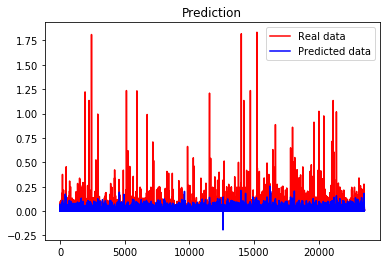

In [65]:
import matplotlib.pyplot as plt
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [66]:
# k-fold clustering
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
# fine tuning with Grid Search
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


In [67]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(40, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    # Adding the output layer
    model.add(Dense(units = 1))
    # Compile model
    model.compile(optimizer = 'adam',loss = 'mean_absolute_percentage_error')
    return model

In [69]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)


kfold = KFold(n_splits=10, random_state=42)
results = cross_val_score(estimator, X_Train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))


Results: -40.14 (2.90) MSE


In [71]:
g_searcher = KerasRegressor(build_fn=baseline_model)

# create a dictionary of hyper-parameters to optimize
#exam problem
parameters = {'batch_size':[25,32], 'nb_epoch':[15,20]}
grid_search = GridSearchCV(estimator = g_searcher, param_grid = parameters, scoring = 'accuracy', cv=10)
grid_search = grid_search.fit(X_Train,y_train)


Epoch 1/1
84763/84763 [==============================] - 9s 105us/step - loss: 194.1933


ValueError: continuous is not supported

In [ ]:

best_parameters = grid_search.best_params 
best_accuracy = grid_search.best_score_

In [106]:
#Show the relationship between number of trees and “Mean Squared Error” of test sample in a line graph. 
#Show the results of all three techniques in a single graph.
import matplotlib.pyplot as plt
from sklearn import metrics

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


#the mse for random forest 
tree_num = [100,200,500,1000]
err_rf_100 = mean_absolute_percentage_error(y_test2, y_pred_100)
err_rf_200 = mean_absolute_percentage_error(y_test2, y_pred_200)
err_rf_500 = mean_absolute_percentage_error(y_test2, y_pred_500)
err_rf_1000 = mean_absolute_percentage_error(y_test2, y_pred_1000)

forest_mse = []
forest_mse.append(err_rf_100)
forest_mse.append(err_rf_200)
forest_mse.append(err_rf_500)
forest_mse.append(err_rf_1000)


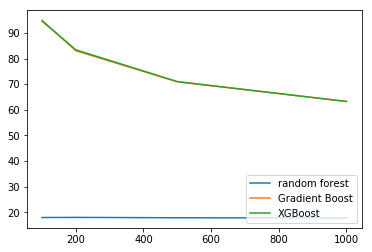

In [109]:
plt.plot(tree_num ,forest_mse, label='random forest')
plt.plot(tree_num ,gb_mse, label='Gradient Boost')
plt.plot(tree_num ,xgb_mse, label='XGBoost')
plt.legend(loc='lower right')
plt.show()

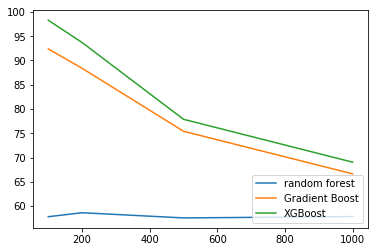

In [98]:
#Plot for different split point(~2014)
plt.plot(tree_num ,forest_mse2, label='random forest')
plt.plot(tree_num ,gb_mse2, label='Gradient Boost')
plt.plot(tree_num ,xgb_mse2, label='XGBoost')
plt.legend(loc='lower right')
plt.show()